In [1]:
import rasterio as rio
import geopandas as gpd
import fiona
import os
import pickle
# enable kml file reading for geopandas
from shapely.geometry import box, Polygon
import pandas as pd
import numpy as np
import leafmap.foliumap as leafmap # use folium backend
import rioxarray as rioxr
from typing import List, Union, Dict
from pathlib import Path
from shapely import box
from PIL import Image
import matplotlib.pyplot as plt
fiona.drvsupport.supported_drivers['KML'] = 'rw'

pd.options.display.max_columns = 50

In [6]:
CRS = 32629

In [7]:
project_path = os.path.expanduser("/home/rustt/Documents/Projects/building_damage")

In [8]:
out_dir_path = os.path.join(project_path, "Data/processed")
raw_data_path = os.path.join(project_path, "Data/raw")
town_loc_path = os.path.join(raw_data_path, "villages_location/Earthquake_marocco_town.kml")

In [9]:
def make_path(file_name, dir=out_dir_path):
    return os.path.join(dir, file_name)

def save_pickle(data, output_path):
    with open(output_path, 'wb') as f:
        pickle.dump(data, f)
        
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [10]:
town = gpd.read_file(make_path("marocco_town.shp", raw_data_path))

In [11]:
name = "Tafeghaghte"

In [78]:
out_test_dir = os.path.join(out_dir_path, name, "test_crop")
if not os.path.exists(out_test_dir): 
    os.mkdir(out_test_dir)

In [80]:
out_dir_path

'/home/rustt/Documents/Projects/building_damage/Data/processed'

In [84]:
platform = "WV03"
rs_town = {}
rs_town[name] = {}

for code_delta, delta in zip([0, 1], ["before", "after"]): 
    root_path = os.path.join(out_dir_path, name)
    df = gpd.read_file(os.path.join(root_path, f"maxar_items_{name}.shp"))
    df = df[(df.after_even == code_delta) & (df.platform == platform)]
    for i, url in df.href.items(): 
        file_name = Path(url).stem
        path = os.path.join(root_path, delta)
        #roi = gpd.read_file(os.path.join(out_dir_path, name, f"roi_{name.lower()}.shp"))
        #bbox = box(*roi.centroid.buffer(100).item().bounds).bounds
        
        bbox = box(*town[town.town_name == name].buffer(100).item().bounds).bounds
        rs = rioxr.open_rasterio(os.path.join(path, f"{file_name}.tif"))
        rs = rs.rio.clip_box(*bbox)
        rs_town[name][delta] = rs
        png_path = os.path.join(path, f"{delta}_{file_name}.png")
        rs.rio.to_raster(png_path, driver="PNG")
        # resize to 512*512 
        img = Image.open(png_path)
        img = img.resize((512, 512))
        img.save(png_path, "PNG")
        print(png_path)

/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/before_10400100405FEB00-visual.png
/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/before_1040010045AE4B00-visual.png
/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/before_10400100797DAC00-visual.png


In [74]:
rs_1 = rs_town[name]["before"]
rs_2 = rs_town[name]["after"]
rs_2_match = rs_2.rio.reproject_match(rs_1)

In [75]:
png_path

'/home/rustt/Documents/Projects/building_damage/Data/processed/Adassil/after/after_10300500E4F91500-visual.png'

In [76]:
rs_2_match.rio.to_raster(png_path, driver="PNG")
# resize to 512*512 
img = Image.open(png_path)
img = img.resize((512, 512))
img.save(png_path, "PNG")
print(png_path)

/home/rustt/Documents/Projects/building_damage/Data/processed/Adassil/after/after_10300500E4F91500-visual.png


In [73]:
rs_town

{'Adassil': {'before': <xarray.DataArray (band: 3, y: 657, x: 657)>
  [1294947 values with dtype=uint8]
  Coordinates:
    * band         (band) int64 1 2 3
    * x            (x) float64 5.481e+05 5.481e+05 ... 5.483e+05 5.483e+05
    * y            (y) float64 3.442e+06 3.442e+06 ... 3.442e+06 3.442e+06
      spatial_ref  int64 0
  Attributes:
      AREA_OR_POINT:             Area
      STATISTICS_APPROXIMATE:    YES
      STATISTICS_MAXIMUM:        255
      STATISTICS_MEAN:           106.32234226084
      STATISTICS_MINIMUM:        0
      STATISTICS_STDDEV:         56.006355747451
      STATISTICS_VALID_PERCENT:  100
      scale_factor:              1.0
      add_offset:                0.0,
  'after': <xarray.DataArray (band: 3, y: 657, x: 657)>
  [1294947 values with dtype=uint8]
  Coordinates:
    * band         (band) int64 1 2 3
    * x            (x) float64 5.481e+05 5.481e+05 ... 5.483e+05 5.483e+05
    * y            (y) float64 3.442e+06 3.442e+06 ... 3.442e+06 3.442e+06


### Pred SAM-CD

In [12]:
pred_sam_path = os.path.join(out_dir_path, name, "pred",f"pred_{name}_tta.pkl")

In [13]:
with open(pred_sam_path, "rb") as fp: 
    pred_sam = pickle.load(fp)

In [14]:
pred_sam = pred_sam.squeeze()

In [15]:
pred_sam

array([[0.00904447, 0.00894747, 0.00886377, ..., 0.00281658, 0.00321565,
        0.00367691],
       [0.00697265, 0.00646869, 0.0060246 , ..., 0.00229494, 0.00276341,
        0.0033317 ],
       [0.00554452, 0.0047885 , 0.00417279, ..., 0.00187178, 0.00237836,
        0.00302535],
       ...,
       [0.00153031, 0.00134645, 0.00118866, ..., 0.00988969, 0.01021608,
        0.01059777],
       [0.00156689, 0.00141292, 0.00127934, ..., 0.01122695, 0.01133183,
        0.01150968],
       [0.00161006, 0.00148698, 0.00138019, ..., 0.01274479, 0.0125721 ,
        0.01251057]], dtype=float32)

(0.0, 0.02)

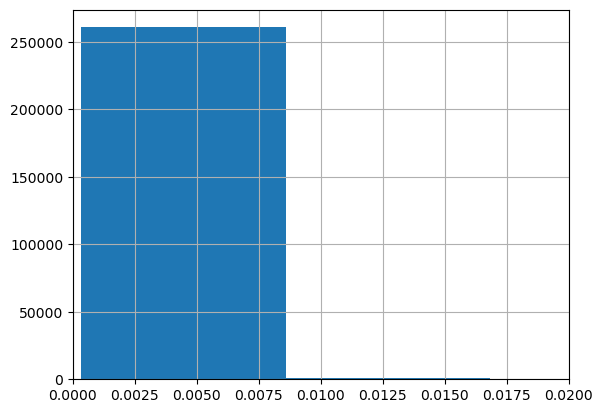

In [22]:
pd.Series(pred_sam.flatten()).hist()
plt.xlim([0., 0.02])

In [18]:
def spread_px_in_range(img: np.array, domain: dict) -> np.array:
    "etalement sur pour une range de pixels - c'est une normalisation"
    
    # min, max for img final
    m, M = domain["dest"][0],  domain["dest"][1]
    # min, max image origin - we cannot use min/max because have pixels deactivated by the mask
    m0, M0 = domain["origin"][0], domain["origin"][1]
    # appply normalisation == recadrage + etalement
    img_norm = m+(img - m0)*((M-m)/(M0-m0)) 

    return img_norm 

In [19]:
domain_mapping = {"origin":(np.min(pred_sam), np.max(pred_sam)), "dest":(0, 255)}

res = spread_px_in_range(pred_sam, domain_mapping)

In [152]:
m=np.min(pred_sam)
M=np.max(pred_sam)
res = (pred_sam - m)*(255/(M-m))

In [155]:
np.quantile(res, 0.6)

1.1283624172210693

In [35]:
mask = 1 - (res > 1.1)

In [36]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
pd.Series(res.flatten()).describe()

count    262144.000000
mean          1.689194
std           5.669262
min           0.000000
25%           0.908473
50%           1.068442
75%           1.261238
max         254.999985
dtype: float64

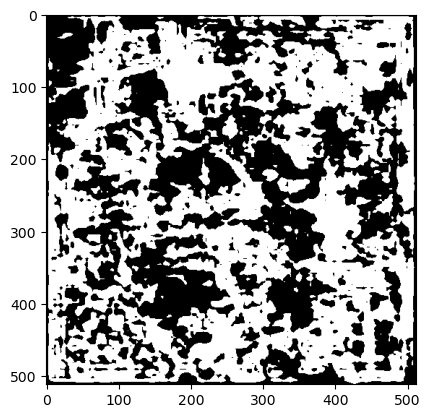

In [38]:
plt.imshow(mask, cmap="grey")

In [158]:
for i_q in np.linspace(0, 1, 11):
    q = np.quantile(res, i_q)
    mask = (res > q)
    plt.imsave(os.path.join(out_dir_path, name, "pred", f"cd_map_3_{i_q}.png"), mask, cmap="grey")

In [ ]:
for q in np.linspace(0, 1, 11):
    print(q)

In [120]:
res.shape

(512, 512)

In [100]:
np.min(pred_sam)

0.00032663322

In [55]:
img = Image.open("test.png")

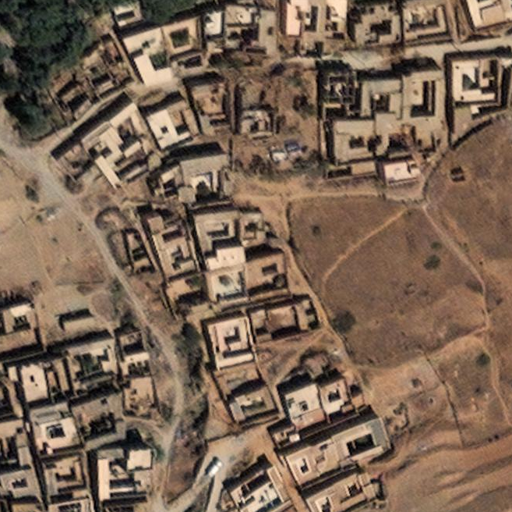

In [57]:
img.resize((512, 512))

In [66]:
roi = gpd.read_file(os.path.join(out_dir_path, name, f"roi_{name.lower()}.shp"))

In [70]:
roi.centroid.buffer(100)

0    POLYGON ((548252.603 3442076.561, 548252.121 3...
dtype: geometry